In [1]:
#Librerias básicas
#================================================================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import duckdb
import glob

# Configuración para las series
# ================================================================================
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm

# Configuración para machine learning
# ================================================================================
import tensorflow as tf
import tensorflow.keras as keras
from pandas.core.frame import DataFrame
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import multiprocessing

# Activar SQL en Python
# ================================================================================
con = duckdb.connect(database=':memory:')

2023-11-08 09:36:50.028196: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 09:36:50.064643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9241] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 09:36:50.064671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 09:36:50.065580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1516] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 09:36:50.071050: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 09:36:50.071775: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
#Url Ari 
url_lcc = "C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet_IA/Curvas_de_luz_cor/"
url    = "C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet_IA/"

In [3]:
#Urls Pater
url_lcc = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/Exoplanet_IA/Curvas_de_luz_cor/"
url    = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/Exoplanet_IA/"

In [4]:
Carac_Stars = pd.read_csv(url+"Carac_Stars.csv")
Carac_Stars

,Kepler_ID,Metalicidad,Clasificacion,incert_clas
0,10797460,0.136,CANDIDATE,1.000
1,10811496,-0.127,FALSE POSITIVE,0.000
2,10848459,-0.522,FALSE POSITIVE,0.000
3,10854555,0.081,CANDIDATE,1.000
4,10872983,-0.067,CANDIDATE,0.992
...,...,...,...,...
7677,10128825,-0.046,CANDIDATE,0.497
7678,10147276,-0.038,FALSE POSITIVE,0.021
7679,10156110,0.082,FALSE POSITIVE,0.000
7680,8460634,-0.556,FALSE POSITIVE,0.000


In [5]:
arch = os.listdir(url_lcc) 
arch.sort()
Stars_list = [star[3:-4] for star in arch]

s_flux  = []
s_err   = []
Id_real = []
for Str in arch:
    serie = pd.read_csv(url_lcc+Str).set_index('time')
    if len(serie) == 1285:
        s_flux.append(np.array(serie['flux']))
        s_err.append(np.array(serie['flux_err']))
        Id_real.append(Str[3:-4])
    else:
        continue


In [6]:
Stars = pd.DataFrame()
Stars["ID"] = Id_real
Stars

,ID
0,10000162
1,10000941
2,10001368
3,10002049
4,10002266
...,...
7201,9993683
7202,9994381
7203,9995402
7204,9995771


In [7]:
Clas_Stars = con.execute("""select S.ID, case when C.Clasificacion == 'CANDIDATE' then 1 
                                              else 0             
                                         end as ClasBin
                            from Carac_Stars C inner join Stars S on (S.ID = C.Kepler_ID)
                            order by S.ID""").df()
Clas_Stars

,ID,ClasBin
0,10000162,1
1,10000941,1
2,10001368,1
3,10002049,1
4,10002266,0
...,...,...
7201,9993683,1
7202,9994381,1
7203,9995402,1
7204,9995771,1


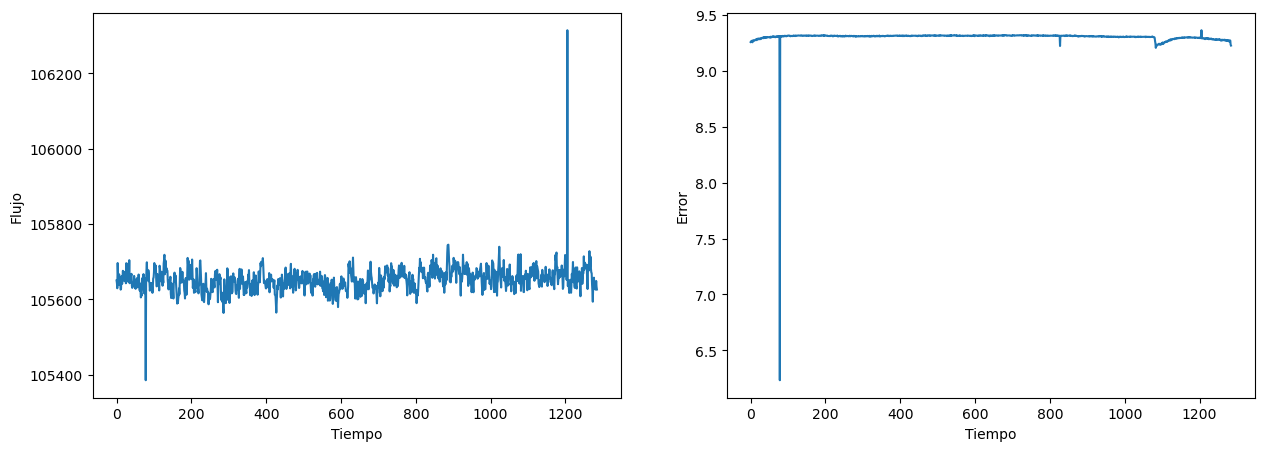

In [8]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(s_flux[198])
#plt.title(f'Curva de luz de la estrella {Stars[190]}') 
plt.ylabel('Flujo')
plt.xlabel('Tiempo')

plt.subplot(1,2,2)

plt.plot(s_err[198])
#plt.title(f'Error de la curva de luz de la estrella {Stars[190]}') 
plt.ylabel('Error')
plt.xlabel('Tiempo')

plt.show()

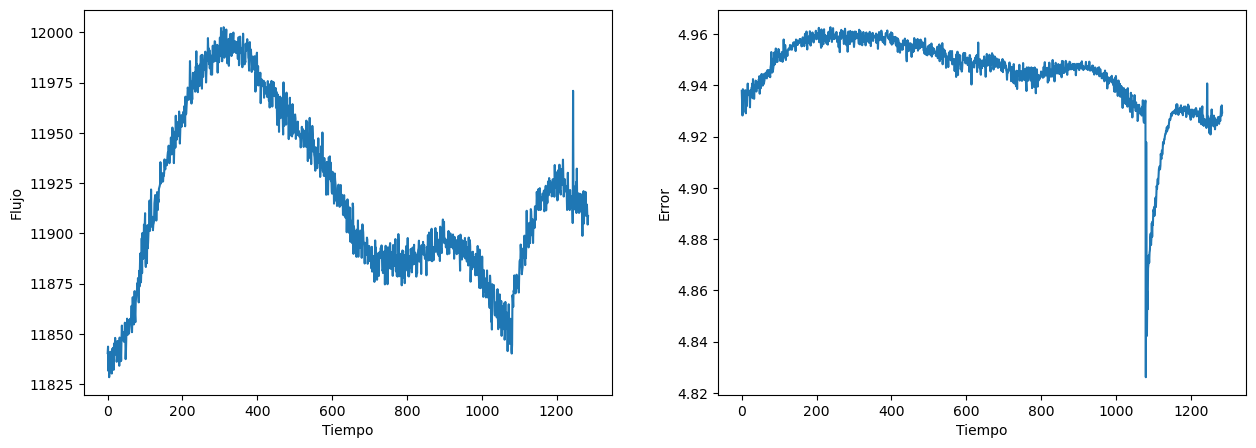

In [30]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(s_flux[6480])
#plt.title(f'Curva de luz de la estrella {Stars[6481]}') 
plt.ylabel('Flujo')
plt.xlabel('Tiempo')

plt.subplot(1,2,2)

plt.plot(s_err[6480])
#plt.title(f'Error de la curva de luz de la estrella {Stars[6481]}') 
plt.ylabel('Error')
plt.xlabel('Tiempo')

plt.show()

## Red Convolucional (CNN)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(np.array(s_flux), 
                                                    np.array(Clas_Stars["ClasBin"]),
                                                    test_size=0.3)

X_val,  X_test,  y_val,  y_test  = train_test_split(X_test, 
                                                    y_test,
                                                    test_size=0.333)
for i in range(len(X_train)):
    mean_i = np.mean(X_train[i])
    std_i  = np.std(X_train[i])
    X_train[i] = (X_train[i] - mean_i)/std_i
    
for i in range(len(X_val)):
    mean_i = np.mean(X_val[i])
    std_i  = np.std(X_val[i])
    X_val[i] = (X_val[i] - mean_i)/std_i

X_train = X_train.reshape((len(X_train), 1285, 1))
X_test  = X_test.reshape((len(X_test), 1285, 1))
X_val   = X_val.reshape((len(X_val), 1285, 1))

print("Tamaño de entrenamiento:",X_train.shape,
      "\nTamaño de validacion:",X_val.shape,
      "\nTamaño de prueba:", X_test.shape,
      "\nDatos totales:",len(X_train)+len(X_val)+len(X_test))

Tamaño de entrenamiento: (5044, 1285, 1) 
Tamaño de validacion: (1442, 1285, 1) 
Tamaño de prueba: (720, 1285, 1) 
Datos totales: 7206


In [29]:
len(y_train[y_train==1])

2138

In [28]:
len(y_train[y_train==0])

2906

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(1285,1)),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1500, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

2023-11-08 09:54:58.185462: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122112000 exceeds 10% of free system memory.
2023-11-08 09:54:58.260700: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122112000 exceeds 10% of free system memory.
2023-11-08 09:54:58.284405: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122112000 exceeds 10% of free system memory.


In [20]:
#CallBack para detener entrenamiento
class MNIST_Callback(tf.keras.callbacks.Callback):
    
    # método dentro de la clase myCallback, heredada de la clase Callback de keras
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.985):
            print("\nSe alcanzó un 98.5% de precisión en la validación! Cancelando Entrenamiento...")
            self.model.stop_training = True

# crea una instancia de clase
accu_callback = MNIST_Callback()

In [21]:
#Compilador del modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1281, 64)          384       
                                                                 
 average_pooling1d_4 (Avera  (None, 640, 64)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_5 (Conv1D)           (None, 636, 64)           20544     
                                                                 
 average_pooling1d_5 (Avera  (None, 318, 64)           0         
 gePooling1D)                                                    
                                                                 
 flatten_2 (Flatten)         (None, 20352)             0         
                                                                 
 dense_4 (Dense)             (None, 1500)             

In [23]:
history = model.fit(X_train, y_train, 
                    epochs=20, 
                    validation_data = (X_val,y_val),
                    batch_size=64,
                    callbacks=[accu_callback])

Epoch 1/20


2023-11-08 09:55:37.945585: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122112000 exceeds 10% of free system memory.
2023-11-08 09:55:37.977296: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122112000 exceeds 10% of free system memory.


79/79 [==============================] - 42s 512ms/step - loss: nan - accuracy: 0.5747 - val_loss: nan - val_accuracy: 0.5846
Epoch 2/20
79/79 [==============================] - 39s 500ms/step - loss: nan - accuracy: 0.5761 - val_loss: nan - val_accuracy: 0.5846
Epoch 3/20
79/79 [==============================] - 40s 501ms/step - loss: nan - accuracy: 0.5761 - val_loss: nan - val_accuracy: 0.5846
Epoch 4/20
79/79 [==============================] - 39s 500ms/step - loss: nan - accuracy: 0.5761 - val_loss: nan - val_accuracy: 0.5846
Epoch 5/20
79/79 [==============================] - 39s 498ms/step - loss: nan - accuracy: 0.5761 - val_loss: nan - val_accuracy: 0.5846
Epoch 6/20
79/79 [==============================] - 40s 501ms/step - loss: nan - accuracy: 0.5761 - val_loss: nan - val_accuracy: 0.5846
Epoch 7/20
79/79 [==============================] - 39s 497ms/step - loss: nan - accuracy: 0.5761 - val_loss: nan - val_accuracy: 0.5846
Epoch 8/20
79/79 [==============================] - 

KeyboardInterrupt: 